Testando um modelo SVC (**Suppport Vector Classification**)
====================================

# O que é? Por que usar?

SVC é um algoritmo de aprendizado supervisionado que encontra o melhor limite que separa classes. Esse limite é um hiperplano, o que faz desse algoritmo efetivo em espaços pluridimensionais. SVC é uma forma específica de implementação de um algoritmo mais geral de aprendizado de máquina, o SVM (Support Vector Machine), só que utilizado para problemas de classificação. 

Nosso _dataset_ tem um grande número de variáveis de interesse e o nosso _target_ (a toxicidade do nanomaterial) depende de relações não lineares complexas entre as variáveis. Além desse aspectos, nosso conjunto de dados é relativamente pequeno. Esses fatores fazem de um modelo utilizando SVC uma excelente escolha teórica para analisar os dados e classificar bem novas entradas. 

Dessa forma, precisamos primeiro checar se o _target_ é uma variável "atacável" por esse método. 

## Importações necessárias

In [24]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer, recall_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Importando o dataset

Esse dado foi tratado anteriormente e os arquivos que documentam a ação estão disponíveis no repositório original. 

In [2]:
df_treated = pd.read_csv("../datasets/HA3B_treated.csv")

## Checando "Toxicity" como target

In [3]:
#Vamos checar se SVC é aplicável 
print("Valores únicos:", df_treated['Toxicity'].unique())
print("Tipo de dado:", df_treated['Toxicity'].dtype)
print("Value counts:")
print(df_treated['Toxicity'].value_counts())
print("Estatísticas:")
print(df_treated['Toxicity'].describe())

Valores únicos: ['Nontoxic' 'Toxic']
Tipo de dado: object
Value counts:
Toxicity
Nontoxic    448
Toxic       175
Name: count, dtype: int64
Estatísticas:
count          623
unique           2
top       Nontoxic
freq           448
Name: Toxicity, dtype: object


Como pudemos ver, há dois valores possíveis: 'Toxic' e 'Nontoxic'. Isso faz do nosso problema um problema de classificação binária, e o SVC é aplicável. 

# Hiperparâmetros relevantes

Hiperparâmetros são configurações que controlam o processo de aprendizado de máquina. Eles são diferentes dos parâmetros que o modelo aprende durante a fase de treinamento, e são controlados pelos cientistas de dados ao instanciar os modelos. É importante que esses hiperparâmetros existam em uma faixa ideal de valores, o que nos obriga a aplicar estratégias de otimização antes de aplicar um modelo aos dados de teste. 

Um SVC tem uma fundamentação matemática centrada em encontrar hiperplanos que maximizem as chamadas "margens" entre classes. Os hiperparâmetros controlam coisas como: o quão estrita a separação de pontos deve ser (hiperparâmetro c), que tipo de barreira de decisão usar (kernel) e o quão complexa essa barreira pode ser (gamma, degree). É vital otimizá-los para poder obter um modelo funcional que não superestime ou subestime a contribuição de uma variável.

Considerando o algoritmo que vamos aplicar, há 5 hiperparâmetros considerados **fundamentais**:

- `C` (parâmetro regularizador): controla a troca entre tamanho da margem e erro de classificação, um C pequeno tem melhor generalização, já um C maior tem um risco de _overfitting_.

- `kernel` (tipo de kernel): controla o formato da fronteira de decisão

- `gamma` (coeficiente do kernel): influencia o alcance de cada ponto individual no treinamento

- `degree` (grau do polinomial): caso o kernel seja polinomial, controla a complexidade do polinômio

- `coef0` (termo independente): controla o deslocamento em kernels polinomiais ou sigmóides

Há também um parâmetro chamado `class_weight` que nos auxilia a lidar com variáveis ditas "não-balanceadas": basicamente esse hiperparâmetro decide se o modelo vai se importar mais com a acurácia no geral ou na identificação correta de _outliers_. 

Para encontrar essas faixas ideias, utilizamos otimização bayesiana, através do Optuna, caminhando pelos passos a seguir:


## Preparando os dados

In [4]:
#Splitting básico
X = df_treated.drop('Toxicity', axis=1)
y = df_treated['Toxicity']


Aplicando codificação de 0 para 'Nontoxic' e 1 para 'Toxic', o que é importante visto que faremos uso do `sci-kit`, que só trabalha com targets numéricos:

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

Em seguida faremos a divisão entre treino e teste:


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

## Função objetivo

A função objetivo é a função que recebe os hiperparâmetros como input e retorna uma métrica de performance que desejamos maximizar ou minimizar. É através da sua implementação com o Optuna que conseguiremos encontrar o conjunto de hiperparâmetros ideal. 

A função objetivo também comumente possuí uma pipeline, algo como uma linha de produção para o processamento.

In [7]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline 
def funcao_objetivo(trial):
    params = {
        'C': trial.suggest_float('C', 0.01, 1000.0, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf','poly']),
        #Vou fixar class_weight porque faz mais sentido funcional para o target
        'class_weight': 'balanced'
    }

    if params['kernel']!= 'linear':
        params['gamma'] = trial.suggest_float('gamma', 1e-5, 10.0, log=True)
    
    if params['kernel'] == 'poly':
        params['degree'] = trial.suggest_int('degree', 2, 4)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(**params, random_state = 42))
    ])

    cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    #Como o foco é detectar nanopartículas TÓXICAS, façamos uma métrica especializada
    #é o mesmo motivo do pq fixamos class_weight
    toxic_recall_scorer = make_scorer( #make_scorer cria um objeto que o sci-kit pode usar
        recall_score,
        pos_label =1, #1 é Toxic
        greater_is_better=True 
    )
    score= cross_val_score(pipeline, X_train, y_train, cv=cv).mean()

    return score

## Otimização

Primeiro, criamos um estudo no Optuna: 

In [8]:
study = optuna.create_study(
    #a função objetivo retorna "recall values", quanto maior melhor
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

[I 2025-11-02 12:10:06,279] A new study created in memory with name: no-name-2eee8d1f-3c09-475f-8a20-47396d0f88ad


Agora, rodamos a otimização propriamente dita:

In [9]:
study.optimize(funcao_objetivo, n_trials=100, timeout=3600)  

[I 2025-11-02 12:10:06,342] Trial 0 finished with value: 0.7752323232323233 and parameters: {'C': 0.7459343285726545, 'kernel': 'linear'}. Best is trial 0 with value: 0.7752323232323233.
[I 2025-11-02 12:10:06,391] Trial 1 finished with value: 0.6327070707070707 and parameters: {'C': 0.06026889128682508, 'kernel': 'poly', 'gamma': 0.040428727350273294, 'degree': 4}. Best is trial 0 with value: 0.7752323232323233.
[I 2025-11-02 12:10:06,438] Trial 2 finished with value: 0.6447474747474747 and parameters: {'C': 0.012674255898937233, 'kernel': 'linear'}. Best is trial 0 with value: 0.7752323232323233.
[I 2025-11-02 12:10:06,488] Trial 3 finished with value: 0.5451313131313131 and parameters: {'C': 0.08111941985431921, 'kernel': 'poly', 'gamma': 0.0039054412752107894, 'degree': 2}. Best is trial 0 with value: 0.7752323232323233.
[I 2025-11-02 12:10:06,556] Trial 4 finished with value: 0.6888686868686869 and parameters: {'C': 11.462107403425028, 'kernel': 'poly', 'gamma': 0.0054502936945582

Agora temos informações dos melhores resultados:

In [11]:
hiper_otm= study.best_params

print("Resultado da otimização:")
print(f"Melhor score de recall tóxico: {study.best_value:.4f} \n")
print("Melhores hiperparâmetros encontrados:")
for chave, valor in study.best_params.items():
    print(f"  {chave}: {valor}")

Resultado da otimização:
Melhor score de recall tóxico: 0.9137 

Melhores hiperparâmetros encontrados:
  C: 931.5666345772175
  kernel: linear


De posse dos nossos hiperparâmetros otimizados, podemos aplicá-los no nosso modelo.

# Instanciando SVC final

Agora estamos no passo final: instanciar o modelo, aplicar os dados de treino e finalmente expô-los aos dados de teste. Faremos isso usando um Pipeline novamente:

In [12]:
pipeline_final = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(**hiper_otm, random_state=42))
])


Agora, treinamos em todo o dado de treino:

In [15]:
pipeline_final.fit(X_train, y_train);

Finalmente, avaliamso o modelo em dados de teste, não vistos anteriormente:

In [16]:
y_pred = pipeline_final.predict(X_test)

# Resultados

Agora calculamos os resultados de performance. Vamos utilizar nosso _recall_score_ e o _accuracy_score_ como métricas:

In [18]:
recall_teste = recall_score(y_test, y_pred, pos_label=1)
acuracia_teste = accuracy_score(y_test, y_pred)

print(f'Recall score dos dados de teste {recall_teste:.4f}')
print(f'Acurácia: {acuracia_teste:.4f}')

Recall score dos dados de teste 0.8000
Acurácia: 0.9280


Calculemos também algo chamado de gap de performance, uma boa métrica para garantir se há _overfitting_ ou _underfitting_:

In [19]:
performance_gap = study.best_value - recall_teste
print(f"   Recall após validação cruzada: {study.best_value:.4f}")
print(f"   Recall de teste:      {recall_teste:.4f}")
print(f"   Gap de performance:  {performance_gap:.4f}")

if performance_gap > 0.1:
    print("Overfitting alto.")
else: 
    print("Overfitting baixo.")

   Recall após validação cruzada: 0.9137
   Recall de teste:      0.8000
   Gap de performance:  0.1137
Overfitting alto.


Vamos também obter o _classification_report_:


In [22]:
print("Classification Report: ")
print(classification_report(y_test, y_pred, target_names=['Nontoxic', 'Toxic']))

Classification Report: 
              precision    recall  f1-score   support

    Nontoxic       0.93      0.98      0.95        90
       Toxic       0.93      0.80      0.86        35

    accuracy                           0.93       125
   macro avg       0.93      0.89      0.91       125
weighted avg       0.93      0.93      0.93       125



Finalmente, podemos utilizar uma matriz de confusão:

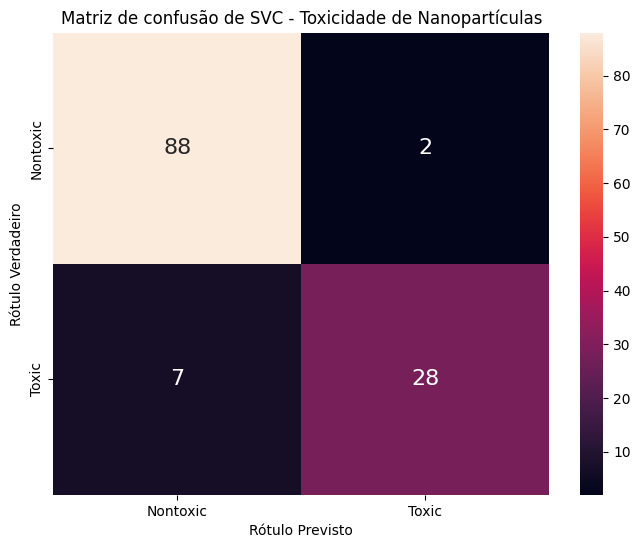

In [28]:
ordem_labels=[0,1]
matriz_conf=confusion_matrix(y_test, y_pred, labels=ordem_labels)
df_conf= pd.DataFrame(matriz_conf, ordem_labels, ordem_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}, fmt='d', 
            xticklabels=['Nontoxic', 'Toxic'], 
            yticklabels=['Nontoxic', 'Toxic'])
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de confusão de SVC - Toxicidade de Nanopartículas')
plt.show()

# Referências

CASSAR, Daniel Roberto. Classificação binária. [Jupyter Notebook], Ilum – Escola de Ciência, Campinas, 2025. 

CASSAR, Daniel Roberto. Otimização de hiperparâmetros com optuna. [Jupyter Notebook], Ilum – Escola de Ciência, Campinas, 2025.

CASSAR, Daniel Roberto. Validação cruzada e otimização de hiperparâmetros. [Jupyter Notebook], Ilum – Escola de Ciência, Campinas, 2025.

SCIKIT-LEARN DEVELOPERS. sklearn.svm.SVC — Support Vector Classification. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
. Acesso em: 29 out. 2025.